# VAR(1) Signal with Additive White Noise

Here we import nessessary packages 

In [1]:
using Polynomials
using DSP
using Plots
using LinearAlgebra
pyplot()

include("wiener_filter_Matrix_fft.jl")

Crosscov (generic function with 2 methods)

The parameters for this model are defined here.

In [2]:
r = [10,5]
C = diagm(r)

sig_v = [10, 3]
Sig_v = diagm(sig_v)
Sig_v = I


UniformScaling{Bool}
true*I

In [3]:
# r, t = rand(), 100*rand()

# each need modulus less than one for the process to be stationary. 
# Also for the process to be rea-valued r1 and r2 are either real or complex conjugates
r = .7,-.5   #2*rand(2) .- 1;

sig_v = 4
C = zeros(2,2)
C[1,1] = r[1]+r[2]
C[1,2] = -r[1]*r[2]
C[2,:] = [1 0]
C

Sig_v = [sig_v 0;0 0]

2×2 Array{Int64,2}:
 4  0
 0  0

## A Theoretical Solution

All the details for he formulation of `h_ana` are given in the Wiener Filtering Tutorial.

In [4]:
rho_poly = [Poly([1, -(1 + r[i]^2 + sig_v[i]^2)/r[i], 1]) for i = 1:2]
rhos = [roots(poly) for poly in rho_poly]
rho = [rh[ abs.(rh) .< 1][1] for rh in rhos]
d = [rho[i]*((1+r[i]^2)/r[i] - rho[i]) for i=1:2]

M_h = 20
h_ana = zeros(2,2,M_h)
for i = 1:2
    h_ana[i,i,:] = [d[i]; [rho[i].^n*(d[i]-1) for n = 1 : M_h - 1]]
end
h_ana

BoundsError: BoundsError

## Data and Numerical Solution

Here we generate the data

In [5]:
# VAR(1) Process
# C = [-0.4 0; 0 0.2]

# S_sig_minus_ana(z) = inv(I - Phi1.*z^(-1))

# S_sig_ana(z) = S_sig_minus_ana(z)*S_sig_minus_ana(z)'

# S_sig_ana_Maxima(z) = [(-(125*z^3-750*z^2+125*z))/(200*z^4+165*z^3+714*z^2+165*z+200) (-(625*z^3-225*z^2+
#                             (-250)*z))/(200*z^4+165*z^3+714*z^2+165*z+200); (250*z^3+225*z^2+(-625)*z)/
#                             (200*z^4+165*z^3+714*z^2+165*z+200) (250*z^3+1350*z^2+250*z)/(200*z^4+165*z^3+714*z^2+165*z+200)]


p = 1

steps = 1*10^6
discard = 10^4
steps_tot = steps + discard

noise_sig = randn(2,steps_tot)
sig = zeros(2,steps_tot);

sig[:,1:p] = noise_sig[:,1:p] 

for i = p+1 : steps_tot
    sig[:,i] = C*sig[:,i-1] + noise_sig[:,i]
end

sig = sig[:,discard + 1 : steps_tot];

noise_pred = Sig_v*randn(2,steps)
pred = sig .+ noise_pred;

Now we call the program I wrote to Numerically solve the Weiner filter. 

In [6]:
M_out = 20
h_num_fft = vector_wiener_filter_fft(pred, sig,M_out,par = 30);
h_ana = h_num_fft;

Now to verify the preformance.

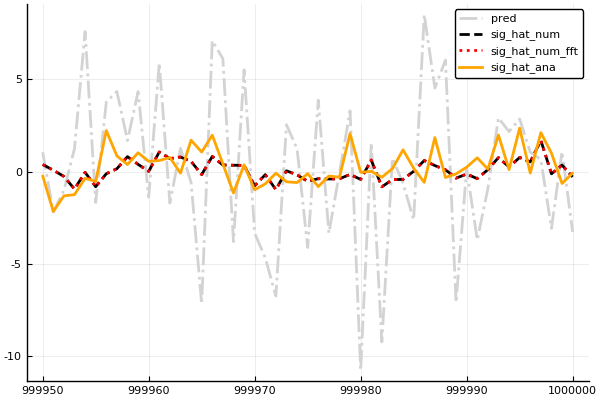

In [11]:
sig_hat_num_fft = zeros(2,steps)
sig_hat_ana = zeros(2,steps)
for i = 1:steps
    sig_hat_num_fft[:,i] = sum([real.(h_num_fft[:,:,k+1])*pred[:,i-k] for k = 0:min(i - 1,M_out - 1)])
    sig_hat_ana[:,i] = sum([real.(h_ana[:,:,k+1])*pred[:,i-k] for k = 0:min(i - 1,M_out - 1)])
end
sig_hat_num_fft

view = 50
start = steps - 50
tim = start:start + view;

plot(tim,[pred[1,tim] sig_hat_num_fft[1,tim] sig_hat_ana[1,tim] sig[1,tim]],
    color=[:lightgrey :black :red :orange], 
    line=(2,[:dashdot :dash :dot :solid ]),
    label=[ "pred" "sig_hat_num" "sig_hat_num_fft" "sig_hat_ana" "sig"])

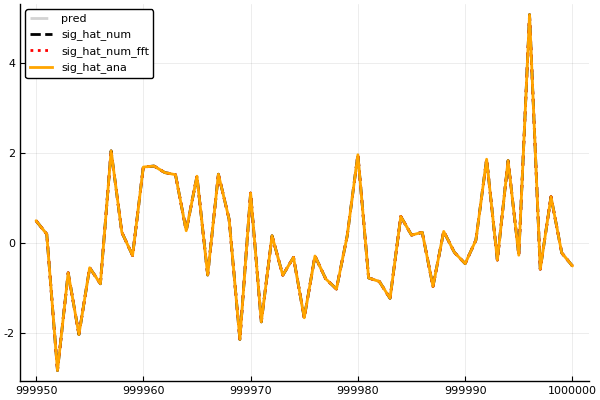

In [12]:
plot(tim,[pred[2,tim] sig_hat_num_fft[2,tim] sig_hat_ana[2,tim] sig[2,tim]],
    color=[:lightgrey :black :red :orange], 
    line=(2,[:dashdot :dash :dot :solid ]),
    label=[ "pred" "sig_hat_num" "sig_hat_num_fft" "sig_hat_ana" "sig"])

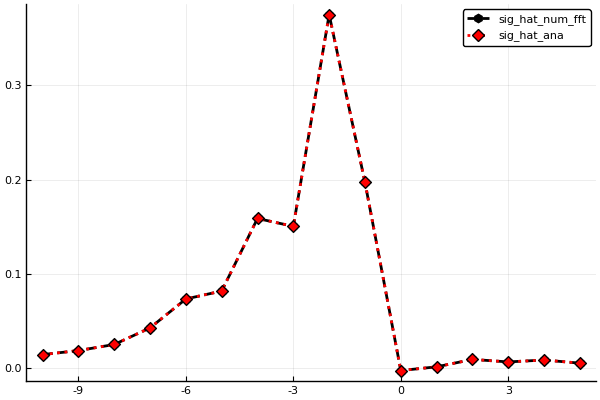

In [16]:
error_num_fft = sig .-sig_hat_num_fft
error_ana = sig .-sig_hat_ana

lags = -10:5
C_ana = Crosscov(error_ana,pred,lags)
C_num_fft = Crosscov(error_num_fft,pred,lags)

plot(lags, [C_num_fft[1,1,:] C_ana[1,1,:]],
    color=[:black :red],
    line=(2,[:dash :dot]),
    label=["sig_hat_num_fft" "sig_hat_ana"],
    marker=([:hex :d],6))

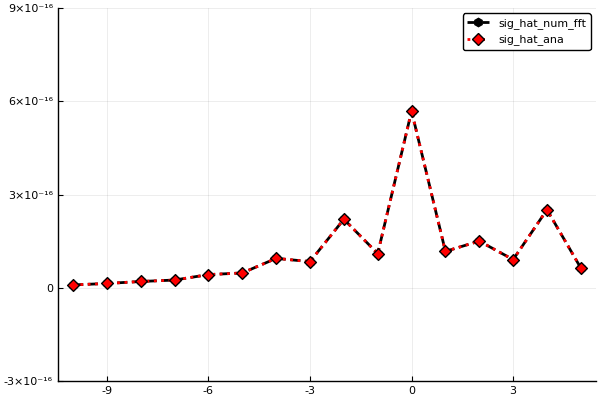

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\JaredMcBride\.julia\packages\PlotUtils\10ojB\src\ticks.jl:283


In [17]:
plot(lags, [C_num_fft[2,2,:] C_ana[2,2,:]],
    color=[:black :red],
    line=(2,[:dash :dot]),
    label=["sig_hat_num_fft" "sig_hat_ana"],
    marker=([:hex :d],6))